# Modeling and Simulation in Python

Chapter 3: Explain

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

## Reading data

Here's the code from the previous notebooks that reads the data.

In [2]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

From here on, we will work in units of billions.

In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

The following function plots the estimates generated by the US Censis and UN DESA, and labels the axes.

In [35]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

### Factoring out the update function

The functions that run the model all look the same except the body of the loop.  So we can factor that part out into a function.

In [36]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

Now the name `update_func` refers to a function object.

In [37]:
update_func1

<function __main__.update_func1>

Which we can confirm by checking its type.

In [38]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [39]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [40]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,value
t_0,1950.000000
t_end,2015.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


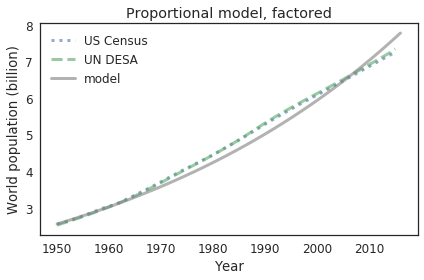

In [41]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [42]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

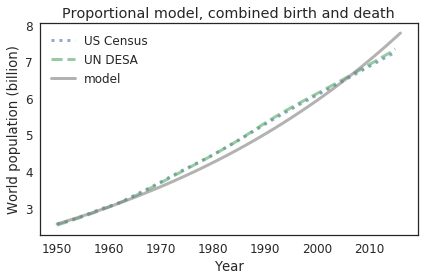

In [43]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

Notice that we have two versions of `update_func` now, defined in different cells (and we'll have a few more version soon).  Remember: when you redefine a function, the new definition replaces the old one.  So you have to keep track of which definition is currently in effect.  If you lose track, you can execute the cell you want again.  
If you really lose track, consider running "Restart & Run All" from the "Kernel" menu, which clear out all variables and functions, and re-runs all cells in the notebook, in order.

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write a version of `update_func2` that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.

Note: Don't forget the `return` statement.

In [44]:
# Solution

def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980:
        net_growth = system.alpha1 * pop
    else:
        net_growth = system.alpha2 * pop
    return pop + net_growth

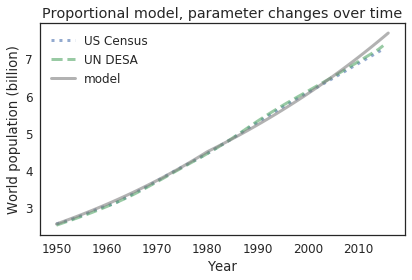

In [45]:
# Solution

system.alpha1 = 0.019
system.alpha2 = 0.015

results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, parameter changes over time')

### Quadratic growth

Here's the implementation of the quadratic growth model.

In [46]:
def update_func_quad(pop, t, system):
    """Compute the population next year with a quadratic model.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

And here are the results.  Can you find values for the parameters that make the model fit better?

Saving figure to file chap03-fig04.pdf


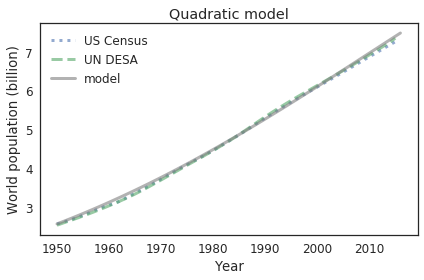

In [47]:
system.alpha = 0.025
system.beta = -0.0018

results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')
savefig('chap03-fig04.pdf')

To understand the quadratic model better, let's plot net growth as a function of population.

In [76]:
pop_array = linspace(0, 15, 100)
net_growth_array = system.alpha * pop_array + system.beta * pop_array**2
None

Here's what it looks like.

Saving figure to file chap03-fig05.pdf


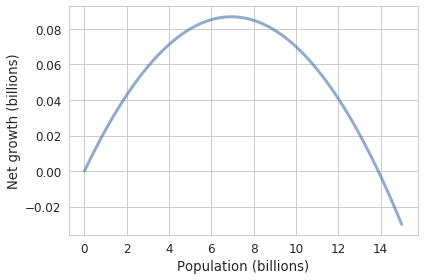

In [79]:
sns.set_style('whitegrid')

plot(pop_array, net_growth_array)
decorate(xlabel='Population (billions)',
         ylabel='Net growth (billions)')
savefig('chap03-fig05.pdf')

sns.set_style('white')

Here's what it looks like.  Remember that the x axis is population now, not time.

It looks like the growth rate passes through 0 when the population is a little less than 14 billion.

In the book we found that the net growth is 0 when the population is $-\alpha/\beta$:

In [78]:
-system.alpha / system.beta

13.88888888888889

This is the equilibrium the population tends toward.

`sns` is a library called Seaborn which provides functions that control the appearance of plots.  In this case I want a grid to make it easier to estimate the population where the growth rate crosses through 0.

## Exercises

**Exercise:** In the book, I present a different way to parameterize the quadratic model:

$ \Delta p = r p (1 - p / K) $

where $r=\alpha$ and $K=-\alpha/\beta$.  Write a version of `update_func` that implements this version of the model.  Test it by computing system variables `r` and `K` equivalent to `alpha` and `beta`, and confirm that you get the same results. 

In [51]:
# Solution

system.r = system.alpha
system.K = -system.alpha/system.beta

system.r, system.K

(0.025, 13.88888888888889)

In [52]:
# Solution

def update_func_quad2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.r * pop * (1 - pop / system.K)
    return pop + net_growth

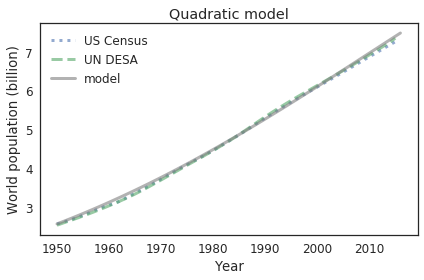

In [53]:
# Solution

results = run_simulation(system, update_func_quad2)
plot_results(census, un, results, 'Quadratic model')

## Optional exercise

The following exercise provides a chance to practice what you have learned so far, and maybe develop a different growth model.  If you feel comfortable with what we have done so far, you might want to give it a try.

**Optional Exercise:** On the Wikipedia page about world population estimates, the first table contains estimates for prehistoric populations.  The following cells process this table and plot some of the results.

Select `table1`, which is the second table on the page.

In [54]:
table1 = tables[1]
table1.head()

,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,
-10000,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
-9000,NaN,NaN,NaN,4.,NaN,NaN,NaN,NaN,NaN,NaN
-8000,5.0,NaN,NaN,5.,NaN,NaN,NaN,NaN,NaN,NaN
-7000,NaN,NaN,NaN,8.,NaN,NaN,NaN,NaN,NaN,NaN
-6000,NaN,NaN,NaN,11.,NaN,NaN,NaN,NaN,NaN,NaN


Not all agencies and researchers provided estimates for the same dates.  Again `NaN` is the special value that indicates missing data.

In [55]:
table1.tail()

,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,
1913,NaN,NaN,1793.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1920,NaN,1860.0,1863.,1912.,NaN,NaN,NaN,NaN,NaN,1968.
1925,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN
1930,NaN,2070.0,NaN,2092.,NaN,NaN,NaN,NaN,NaN,2145.
1940,NaN,2300.0,2299.,2307.,NaN,NaN,NaN,NaN,NaN,2340.


Some of the estimates are in a form we can't read as numbers.  We could clean them up by hand, but for simplicity I'll replace any value that has an `M` in it with `NaN`.

In [56]:
table1.replace('M', np.nan, regex=True, inplace=True)

Again, we'll replace the long column names with more convenient abbreviations.

In [57]:
table1.columns = ['prb', 'un', 'maddison', 'hyde', 'tanton', 
                  'biraben', 'mj', 'thomlinson', 'durand', 'clark']

This function plots selected estimates.

In [58]:
def plot_prehistory(table):
    """Plots population estimates.
    
    table: DataFrame
    """
    plot(table.prb, 'ro', label='PRB')
    plot(table.un, 'co', label='UN')
    plot(table.hyde, 'yo', label='HYDE')
    plot(table.tanton, 'go', label='Tanton')
    plot(table.biraben, 'bo', label='Biraben')
    plot(table.mj, 'mo', label='McEvedy & Jones')

Here are the results.  Notice that we are working in millions now, not billions.

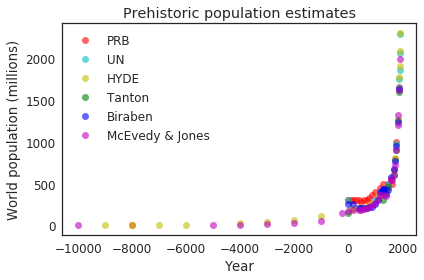

In [59]:
plot_prehistory(table1)
decorate(xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistoric population estimates')

We can use `xlim` to zoom in on everything after Year 0.

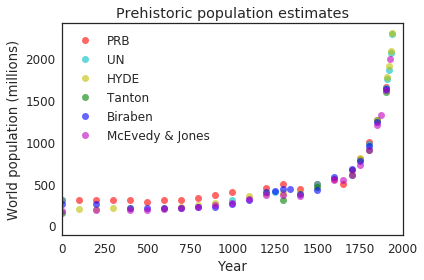

In [60]:
plot_prehistory(table1)
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistoric population estimates')

See if you can find a model that fits these data well from Year -1000 to 1940, or from Year 1 to 1940.

How well does your best model predict actual population growth from 1950 to the present?

In [61]:
# Solution

def update_func_prop(pop, t, system):
    """Compute the population next year with proportional growth.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha * pop
    return pop + net_growth

In [62]:
# Solution

t_0 = 1
p_0 = table1.biraben[t_0]

prehistory = System(t_0=t_0, 
                    t_end=2016,
                    p_0=p_0,
                    alpha=0.0011)

,value
t_0,1.0000
t_end,2016.0000
p_0,255.0000
alpha,0.0011


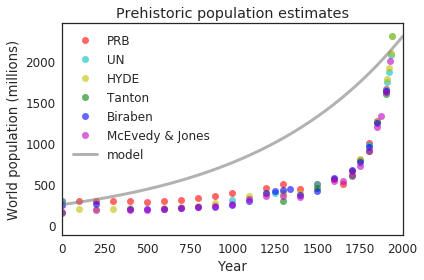

In [65]:
# Solution

results = run_simulation(prehistory, update_func_prop)
plot_prehistory(table1)
plot(results, color='gray', label='model')
decorate(xlim=[0, 2000], xlabel='Year', 
         ylabel='World population (millions)',
         title='Prehistoric population estimates')

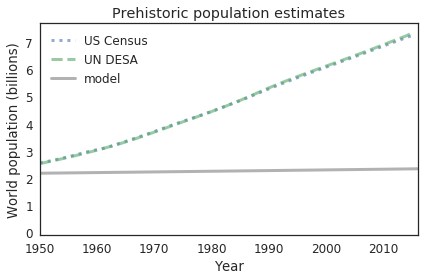

In [66]:
# Solution

plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
plot(results / 1000, color='gray', label='model')
decorate(xlim=[1950, 2016], xlabel='Year', 
         ylabel='World population (billions)',
         title='Prehistoric population estimates')

### Disfunctions

When people first learn about functions, there are a few things they often find confusing.  In this section I present and explain some common problems with functions.

As an example, suppose you want a function that takes a `System` object, with variables `alpha` and `beta`, as a parameter and computes the carrying capacity, `-alpha/beta`.  Here's a good solution:

In [67]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

13.88888888888889


Now let's see all the ways that can go wrong.

**Disfunction #1:** Not using parameters.  In the following version, the function doesn't take any parameters; when `system` appears inside the function, it refers to the object we created outside the function.


In [68]:
def carrying_capacity():
    K = -system.alpha / system.beta
    return K
    
system = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity()
print(pop)

13.88888888888889


This version actually works, but it is not as versatile as it could be.  If there are several `System` objects, this function can only work with one of them, and only if it is named `system`.

**Disfunction #2:** Clobbering the parameters.  When people first learn about parameters, they often write functions like this:

In [69]:
def carrying_capacity(system):
    system = System(alpha=0.025, beta=-0.0018)
    K = -system.alpha / system.beta
    return K
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

13.88888888888889


In this example, we have a `System` object named `sys1` that gets passed as an argument to `carrying_capacity`.  But when the function runs, it ignores the argument and immediately replaces it with a new `System` object.  As a result, this function always returns the same value, no matter what argument is passed.

When you write a function, you generally don't know what the values of the parameters will be.  Your job is to write a function that works for any valid values.  If you assign your own values to the parameters, you defeat the whole purpose of functions.


**Disfunction #3:** No return value.  Here's a version that computes the value of `K` but doesn't return it.

In [70]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    
sys1 = System(alpha=0.025, beta=-0.0018)
pop = carrying_capacity(sys1)
print(pop)

None


A function that doesn't have a return statement always returns a special value called `None`, so in this example the value of `pop` is `None`.  If you are debugging a program and find that the value of a variable is `None` when it shouldn't be, a function without a return statement is a likely cause.

**Disfunction #4:** Ignoring the return value.  Finally, here's a version where the function is correct, but the way it's used is not.

In [71]:
def carrying_capacity(system):
    K = -system.alpha / system.beta
    return K
    
sys2 = System(alpha=0.025, beta=-0.0018)
carrying_capacity(sys2)
print(K)

NameError: name 'K' is not defined

In this example, `carrying_capacity` runs and returns `K`, but the return value is dropped.

When you call a function that returns a value, you should do something with the result.  Often you assign it to a variable, as in the previous examples, but you can also use it as part of an expression.

For example, you could eliminate the temporary variable `pop` like this:

In [72]:
print(carrying_capacity(sys1))

13.88888888888889


Or if you had more than one system, you could compute the total carrying capacity like this:


In [73]:
total = carrying_capacity(sys1) + carrying_capacity(sys2)
total

27.77777777777778